## Preparción del entorno

In [1]:
# Importes de las librerías necesarias durante la ejecución del código
from google.colab import drive
import os, shutil, pathlib
from tensorflow import keras 
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense, Flatten
import PIL
from tensorflow.keras.layers import BatchNormalization

In [2]:
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Deep Learning"

Mounted at /content/drive
/content/drive/MyDrive/Deep Learning


## División del dataset

El data set utilizado cuenta con imágenes de elefantes africanos y asiáticos para que cada uno pueda ser identificado con su especie correspondiente, cada imagen se identifica con un prefijo en el nombre de cada una (as para asiático y af para africano). Consta de 1028 imágenes en total. Por esto, dividiremos el datasets en datasets más pequeños para train, validation y test, y a su vez cada uno de ellos se dividirá en dos clases (la de elefantes asiáticos y la de elefantes africanos). 


- El dataset de train tendrá 720 imágenes.
- El dataset de validation tendrá 120 imágenes.
- El dataset de test contiene 188 imágenes.

Se utiliza un mayor número de imágenes en el dataset de train para poder entrenar de mejor manera el modelo. 


El dataset fue obtenido de Kaggle en la siguiente liga: 
https://www.kaggle.com/datasets/vivmankar/asian-vs-african-elephant-image-classification

In [3]:
"""
# Solo se realiza una vez, para que se cree el folder y se divida el dataset
  
original_dir = pathlib.Path("train")                           
new_base_dir = pathlib.Path("elephant_small_tt")              
 
def make_subset(subset_name, start_index, end_index):          
    for category in ("as_tr", "af_tr"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}{i}.jpg" 
                  for i in range(start_index, end_index)]
        for fname in fnames:
          shutil.copyfile(src=original_dir / fname, dst=dir / fname)
  
make_subset("train", start_index=1, end_index=360)    
make_subset("validation", start_index=361, end_index=420)
"""

'\n# Solo se realiza una vez, para que se cree el folder y se divida el dataset\n  \noriginal_dir = pathlib.Path("train")                           \nnew_base_dir = pathlib.Path("elephant_small_tt")              \n \ndef make_subset(subset_name, start_index, end_index):          \n    for category in ("as_tr", "af_tr"):\n        dir = new_base_dir / subset_name / category\n        os.makedirs(dir)\n        fnames = [f"{category}{i}.jpg" \n                  for i in range(start_index, end_index)]\n        for fname in fnames:\n          shutil.copyfile(src=original_dir / fname, dst=dir / fname)\n  \nmake_subset("train", start_index=1, end_index=360)    \nmake_subset("validation", start_index=361, end_index=420)\n'

In [4]:
# Declaramos el direcotrio del que se obtendrán las imágenes.
original_dir = pathlib.Path("train")                           
new_base_dir = pathlib.Path("elephant_small_tt")

## Creación y entrenamiento del modelo (primera iteración)

Crearemos un modelo de Red Neuronal Convolutiva (CNN), la cual tendrá varias capas de convolución.

Para la creación del modelo debemos tomar en cuenta lo siguiente: 
- Las primeras tres capas se encargan de la imagen en general, por lo que no toman muchos detalles. 
- Las siguientes capas permiten analizar más de los detalles de las imágenes.

Para esta primera iteración, probaremos con una arquitectura de modelo sencilla, para observar cómo se va comportando el modelo.

Es por esto que para la arquitectura del modelo utilizaremos diferentes capas de convolución y capas de MaxPooling de tamaño 2x2.

Las primeras capas de convolución tendrán como función de activación ReLu, ya que con esta función se llegan a obtener mejores resultados al entrenar el modelo. 

Finalmente, tendremos una capa Flatten y una capa densa que tiene como función de activación una sigmoide, ya que solo se pueden tener dos salidas diferentes. 

In [5]:
# Creación del modelo
model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),
                          layers.Conv2D(filters=256, kernel_size=3, activation="relu"),                          
                          layers.Flatten(),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 256)       295168    
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 256)      0         
 2D)                                                    

Después de la creación del modelo, es momento de compilarlo. Utilizamos el optimizador Adam ya que este es más eficiente.

In [6]:
# Compilamos el modelo
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [7]:
# Dataset para entrenamiento
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=10)
# Dataset para validación
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=10)
# Dataset para test
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=10)

Found 718 files belonging to 2 classes.
Found 118 files belonging to 2 classes.
Found 188 files belonging to 2 classes.


In [8]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (10, 180, 180, 3)
labels batch shape: (10,)


In [9]:
class_names = train_dataset.class_names
print(class_names)

['af_tr', 'as_tr']


In [10]:
# Hacemos fit del modelo
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20, # Se pueden aumentar el número de épocas para que mejore el accuracy del modelo
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.4763

72/72 [==============================] - 67s 775ms/step - loss: 0.7866 - accuracy: 0.4763 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.4735

72/72 [==============================] - 9s 117ms/step - loss: 0.6933 - accuracy: 0.4735 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4610

72/72 [==============================] - 9s 117ms/step - loss: 0.6932 - accuracy: 0.4610 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
72/72 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
72/72 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
72/72 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4749

72/72 [==============================] - 9s 119ms/step - loss: 0.6932 - accuracy: 0.4749 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
72/72 [==============================] - 7s 100ms/step - loss: 0.6932 - accuracy: 0.4694 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/20
72/72 [==============================] - 7s 100ms/step - loss: 0.6932 - accuracy: 0.4526 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/20
72/72 [==============================] - 8s 103ms/step - loss: 0.6932 - accuracy: 0.4889 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 10/20
72/72 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4749

72/72 [==============================] - 8s 115ms/step - loss: 0.6932 - accuracy: 0.4749 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 11/20
72/72 [==============================] - 7s 100ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 12/20
72/72 [==============================] - 7s 100ms/step - loss: 0.6932 - accuracy: 0.4666 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 13/20
72/72 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.4666 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 14/20
72/72 [==============================] - 7s 101ms/step - loss: 0.6932 - accuracy: 0.4805 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 15/20
72/72 [==============================] - 7s 100ms/step - loss: 0.6932 - accuracy: 0.4666 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 16/20
72/72 [==============================] - 7s 100ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 17/20

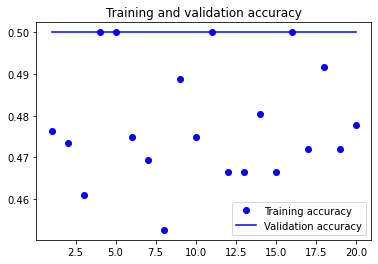

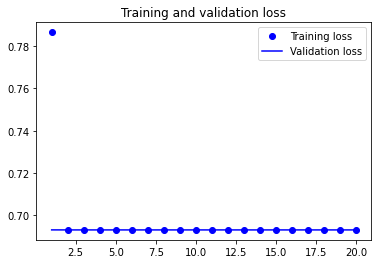

In [11]:
# Graficamos
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_model = keras.models.load_model("convnet_from_scratch")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

19/19 [==============================] - 23s 690ms/step - loss: 0.6931 - accuracy: 0.5160
Test accuracy: 0.516


Como podemos ver, existe un underfitting de nuestro modelo, lo que quiere decir que no está aprendiendo suficiente del dataset. Es por esto que debemos realizar ajustes en los parámetros con el fin de que el modelo mejore. Los valores obtenidos del accuracy no son buenos, por lo que es necesario mejorar para que el modelo sea más preciso, ya que este cuenta solo con 10 capas. 
Para mejorar el modelo, debemos hacer que la red sea más profunda o más ancha y además aumentar el número de épocas. También realizaremos data augmentation para poder tener más imágenes. 

## Creación y entrenamiento del modelo con data augmentation (segunda iteración)

Debido al underfitting del modelo pasado, crearemos un modelo con data augmentation con el fin de intentar mejorar el accuracy del modelo.

In [13]:
# Realizamos data augmentation, ya que nos permite entrenar mejor el modelo teniendo más imágenes con las cuales entrenar este mismo. 
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal",
                                      input_shape=(180,
                                      180,
                                      3)),
                                    layers.RandomCrop(180,180),
                                    layers.RandomContrast(0.15),
                                    layers.RandomRotation(0.1),
                                    layers.RandomZoom(0.2),
                                  ]
                                )

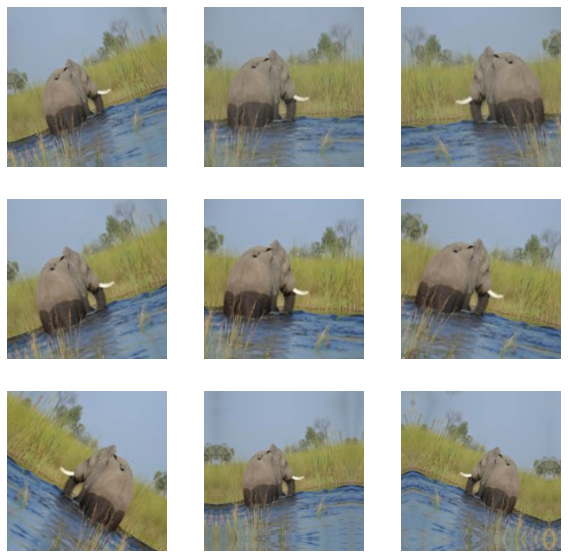

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images, training=True)
    ax = plt.subplot(3, 3, i + 1, xticks=[],yticks=[])
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Con data augmentation podemos ver que se replica la misma imagen con diferentes porcentajes de zoom, ángulos y perspectivas. Esto ayudará a que el modelo aprenda mejor.

Para este nuevo modelo, aumentaremos el número de capas para que este pueda ser más preciso.

El nuevo modelo cuenta con:
- 6 capas convolutivas con acitivación ReLu
- 2 capas de MaxPooling con acitivación ReLu
- 1 capa Flatten con acitivación ReLu
- 3 capas densas con acitivación ReLu
- 1 capa densa con activación sigmoide, ya que hay solo dos clases.

In [15]:
# Creación del modelo
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1 , activation = 'sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                      

In [16]:
# Compilación del modelo
model.compile(loss="binary_crossentropy",
              metrics=["accuracy"]) #optimizer default rmsprop

In [17]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (10, 180, 180, 3)
labels batch shape: (10,)


In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/60


72/72 [==============================] - 16s 151ms/step - loss: 0.7403 - accuracy: 0.4986 - val_loss: 1.5590 - val_accuracy: 0.5000
Epoch 2/60
72/72 [==============================] - 10s 136ms/step - loss: 0.7214 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4915
Epoch 3/60
72/72 [==============================] - 9s 122ms/step - loss: 0.6946 - accuracy: 0.4777 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/60
72/72 [==============================] - 9s 117ms/step - loss: 0.6937 - accuracy: 0.4582 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/60
72/72 [==============================] - 8s 116ms/step - loss: 0.6949 - accuracy: 0.4889 - val_loss: 0.6993 - val_accuracy: 0.5000
Epoch 6/60
72/72 [==============================] - 9s 119ms/step - loss: 0.6948 - accuracy: 0.4833 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/60
72/72 [==============================] - 9s 116ms/step - loss: 0.6997 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/60
72/7

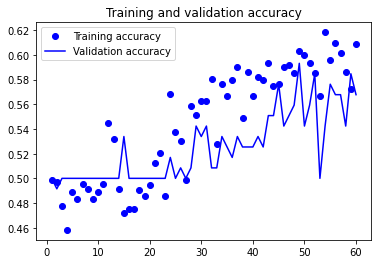

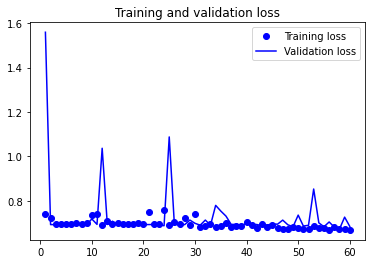

In [19]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
test_model = keras.models.load_model("convnet_from_scratch")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

19/19 [==============================] - 3s 74ms/step - loss: 0.6931 - accuracy: 0.5160
Test accuracy: 0.516


Podemos ver que la precisión del modelo sigue sin ser buena, por lo que existe un underfitting a pesar del data augmentation por lo que tenemos que realizar más modificaciones en las capas del modelo, para mejorarlo. 

A pesar de haber aumentado el número de capas a 13 y realizado data augmentation, el modelo continúa con un accuracy muy bajo.

## Creación y entrenamiento del modelo (tercera iteración)

Para mejorar el modelo, agregamos una capa y además aumentamos los filtros, por lo que es más profunda y más ancha. 
Utilizamos como funciones de activación ReLu y sigmoide.
Este nuevo modelocuenta con: 
- 4 capas de convolución
- 4 capas de Max Pooling
- 1 capa Flatten
- 3 capas densas



En esta iteración, modificamos los filtros para que el modelo fuera más ancho y verificar si con esta arquitectura la precisión del modelo mejora.

In [21]:
model= keras.Sequential([
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [22]:
# Compilación del modelo
model.compile(loss="binary_crossentropy",
              optimizer='adamax',
              metrics=["accuracy"])

In [23]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (10, 180, 180, 3)
labels batch shape: (10,)


In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
72/72 [==============================] - 5s 52ms/step - loss: 2.0703 - accuracy: 0.5028 - val_loss: 0.6944 - val_accuracy: 0.5254
Epoch 2/30
72/72 [==============================] - 2s 33ms/step - loss: 0.6874 - accuracy: 0.5655 - val_loss: 0.7375 - val_accuracy: 0.5085
Epoch 3/30
72/72 [==============================] - 3s 34ms/step - loss: 0.6856 - accuracy: 0.5585 - val_loss: 0.6945 - val_accuracy: 0.5593
Epoch 4/30
72/72 [==============================] - 3s 37ms/step - loss: 0.6683 - accuracy: 0.5891 - val_loss: 0.7156 - val_accuracy: 0.5254
Epoch 5/30
72/72 [==============================] - 3s 37ms/step - loss: 0.6284 - accuracy: 0.6323 - val_loss: 0.7550 - val_accuracy: 0.5593
Epoch 6/30
72/72 [==============================] - 3s 35ms/step - loss: 0.5810 - accuracy: 0.6866 - val_loss: 0.8046 - val_accuracy: 0.5932
Epoch 7/30
72/72 [==============================] - 3s 35ms/step - loss: 0.5580 - accuracy: 0.7033 - val_loss: 0.8461 - val_accuracy: 0.5678
Epoch 8/30
72

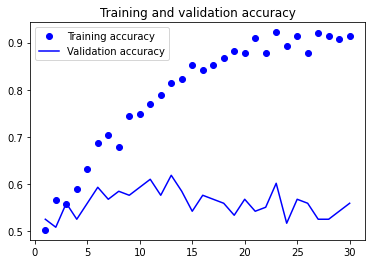

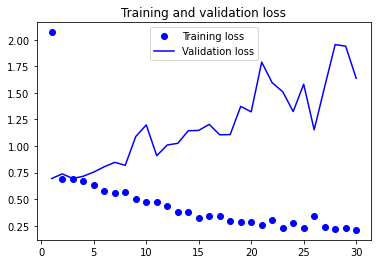

In [25]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model("convnet_from_scratch")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

19/19 [==============================] - 3s 75ms/step - loss: 0.6931 - accuracy: 0.5160
Test accuracy: 0.516


Con esta modificación del modelo, logramos obtener un accuracy más alto del modelo, sin embargo, el accuracy del dataset de validación continúa siendo muy bajo, por lo que existe una diferencia muy grande entre ambos valores. Esto quiere decir que el modelo está haciendo un overfitting, ya que aprende las imágenes del dataset de train sin embargo, no es capaz de realizar predicciones correctas con imágenes de otro dataset. Esto se puede observar desde las primeras épocas. Es por esto que debemos realizar otras modificaciones para mejorar el accuracy sin caer en overfitting.

## Creación y entrenamiento del modelo con transfer learning (cuarta iteración)

Debido al bajo accuracy obtenido con modelos creados, utilizaremos transfer learning, con un modelo ya preentrenado cambiando ciertos parámetros y las capas de salida de este.

Agregamos una capa Flatten, dos capas densas y la capa de data augmentation. 

En las últimas capas densas, aumentamos los filtros para que las capas sean más anchas.


El modelo preentrenado tiene los siguientes parámetros: 
- Include_top=False: para usar nuestras propias capas de entrada y de salida.
- Utilizamos los pesos predefinidos por Imagenet.
- Tamaño de la imagen de entrada
- Pooling: utilizamos average pooling.
- Clases: número de clases que están dentro del dataset.

Al modelo preentrendado agregamos: 
- Una capa de data augmentation
- Una capa Flatten
- Una capa Densa con una función de activación ReLu
- Una capa Densa con una función de activación softmax, ya que regresa un vector de probabilidades.


In [27]:
resnet_model = keras.Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(180,180,3),
    pooling="avg",
    classes=2
)

for layer in pretrained_model.layers:
  layer.trainable = False

resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 41, 128)       73856     
                                                       

Utilizamos el optimizer Adam ya que es bueno, pero además utilizamos learning rate para poder modificar los hiperparámetros hasta encontrar el valor que mejor ajuste.

In [28]:
# Compilamos el modelo
resnet_model.compile(
    optimizer=Adam(learning_rate=0.005),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"]
)

In [29]:
epochs = 25
history = resnet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/25


72/72 [==============================] - 15s 115ms/step - loss: 3.5418 - accuracy: 0.5891 - val_loss: 0.7914 - val_accuracy: 0.7034
Epoch 2/25
72/72 [==============================] - 7s 91ms/step - loss: 0.6414 - accuracy: 0.6741 - val_loss: 0.5758 - val_accuracy: 0.7288
Epoch 3/25
72/72 [==============================] - 7s 93ms/step - loss: 0.5637 - accuracy: 0.7145 - val_loss: 0.5742 - val_accuracy: 0.7119
Epoch 4/25
72/72 [==============================] - 7s 99ms/step - loss: 0.5235 - accuracy: 0.7284 - val_loss: 0.5979 - val_accuracy: 0.7034
Epoch 5/25
72/72 [==============================] - 7s 100ms/step - loss: 0.5381 - accuracy: 0.7340 - val_loss: 0.5381 - val_accuracy: 0.7373
Epoch 6/25
72/72 [==============================] - 7s 95ms/step - loss: 0.4871 - accuracy: 0.7730 - val_loss: 0.5602 - val_accuracy: 0.7288
Epoch 7/25
72/72 [==============================] - 7s 93ms/step - loss: 0.4984 - accuracy: 0.7549 - val_loss: 0.5854 - val_accuracy: 0.7203
Epoch 8/25
72/72 [===

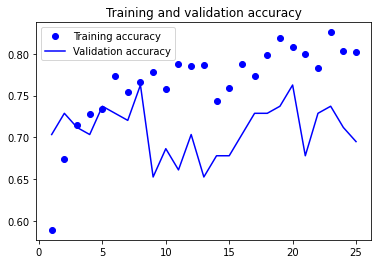

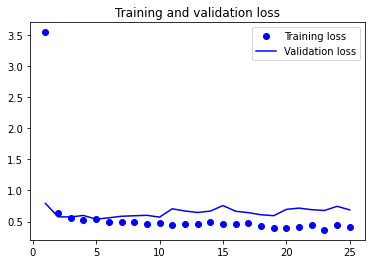

In [30]:
# Graficamos
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [31]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

19/19 [==============================] - 2s 56ms/step - loss: 0.6747 - accuracy: 0.6383
Test accuracy: 0.638


Podemos ver que el accuracy del modelo mejoró, sin embargo, este sigue siendo bajo a pesar de trabajar con un modelo preentrenado. 
Esto puede deberse a que el dataset tiene mucho ruido, imágenes que no corresponden a un elefante, entre otras. Esto está especificado en la descripción del dataset en la página de Kaggle. El ruido no permite que el modelo aprenda de manera correcta, por lo que el modelo no es muy preciso. 

Por otro lado, analizando los valores de accuracy y accuracy del dataset de validación y las gráficas podemos observar que en momentos existe un ligero overfitting pero este no es muy importante. Sin embargo, a partir de ciertas épocas podemos observar un overfitting más importante.

Con ayuda de data augmentation, transfer learning y variando el learning rate, logramos que el modelo tuviera un accuracy más alto que el que habíamos obtenido a lo largo del resto de los modelos creados. 

## Predicciones con nuevas imágenes

Se podrá probar el modelo con imágenes que no se encuentren en el dataset, solo agregando el URL de una imagen y modificando su tamaño si necesario.

In [32]:
predict = "https://drive.google.com/uc?export=view&id=17OkXEhbg36MVbl2gyF6aIe-XDaCZeGYV"
path = tf.keras.utils.get_file(
    "elephant",
    origin = predict
)

img = tf.keras.utils.load_img(path, target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    ))

1/1 [==============================] - 0s 257ms/step
This image most likely belongs to af_tr with a 100.00 percent confidence.
